# 调参

In [9]:
import os
import sys
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
current_path = os.getcwd()

# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))
# Importing the custom module
from Utools.draw import plot_feature_importance
from Utools.SingleModel import SingleModel


In [ ]:
# Load data (assuming you have dft_train_X, dft_train_y)
file_dir = os.path.join(current_path, './Data')
# Load dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_train_set.csv'))
dft_all_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_all_train_y = dft_train['band_gap']
# Load dft test data
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_test_set.csv'))
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
dft_all_train_X.shape, dft_all_train_y.shape, dft_test_X.shape, dft_test_y.shape

In [11]:
# 从dft_train_X中抽取出一份验证集
mp_unique_comp = dft_train['composition'].unique()
len(mp_unique_comp)

8237

In [12]:
import random
# 从mp_unique_comp中随机采样组成
random.seed(RANDOM_SEED)
random_index = random.sample(range(len(mp_unique_comp)), round(dft_train.shape[0]*0.1))
mp_val_comp = mp_unique_comp[random_index]
dft_train_set = dft_train[~dft_train['composition'].isin(mp_val_comp)]
dft_val_set = dft_train[dft_train['composition'].isin(mp_val_comp)]
print(f'MP训练集大小：{len(dft_train_set)}')
print(f'MP验证集大小：{len(dft_val_set)}')

MP训练集大小：7437
MP验证集大小：831


In [13]:
# Prepare data
dft_train_X = dft_train_set.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train_set['band_gap']
# 
dft_val_X = dft_val_set.drop(columns=['composition', 'band_gap'])
dft_val_y = dft_val_set['band_gap']

dft_train_X.shape, dft_train_y.shape, dft_val_X.shape, dft_val_y.shape

((7437, 132), (7437,), (831, 132), (831,))

## 7. SVR

In [14]:
# Define the model
MODEL_NAME = 'SVR'

In [ ]:
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'C', 'epsilon', 'gamma', 'R²', 'RMSE', 'MAE'])
# Define the hyperparameter search space
import itertools

params = {
    'C': [0.1, 1, 10, 25, 50, 75, 100],
    'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
    'epsilon': [0.01, 0.05, 0.07, 0.5, 0.1, 1],
}
n_iter = 50
scaler = StandardScaler()
scaled_dft_train_X = scaler.fit_transform(dft_train_X)
scaled_dft_val_X = scaler.transform(dft_val_X)

# 生成所有可能的参数组合
all_params = list(itertools.product(params['C'], params['gamma'], params['epsilon']))

# 随机选择 n_iter 个组合
if n_iter > len(all_params):
    sampled_params_list = all_params
    print(f"Warning: n_iter is larger than the number of all possible combinations. Using all {len(all_params)} combinations.")
else:
    sampled_params_list = random.sample(all_params, n_iter)

for i, sampled_params_tuple in enumerate(sampled_params_list):
    sampled_params = {
        'C': sampled_params_tuple[0],
        'gamma': sampled_params_tuple[1],
        'epsilon': sampled_params_tuple[2]
    }

    print(f"[Iter {i+1}/{len(sampled_params_list)}] Sampled parameters: {sampled_params}")

    # Create SVR
    model = SVR(kernel='rbf', C=sampled_params['C'], epsilon=sampled_params['epsilon'], gamma=sampled_params['gamma'])
    # fit the model
    model.fit(scaled_dft_train_X, dft_train_y)
    # Predict
    train_pred = model.predict(scaled_dft_train_X)
    val_pred = model.predict(scaled_dft_val_X)
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(dft_train_y, train_pred))
    val_rmse = np.sqrt(mean_squared_error(dft_val_y, val_pred))
    train_r2 = r2_score(dft_train_y, train_pred)
    val_r2 = r2_score(dft_val_y, val_pred)
    train_mae = mean_absolute_error(dft_train_y, train_pred)
    val_mae = mean_absolute_error(dft_val_y, val_pred)

    # Append metrics to DataFrame
    model_metrics.loc[len(model_metrics)] ={
        'Model': MODEL_NAME,
        'Error_Type': 'Train',
        'C': sampled_params['C'],
        'epsilon': sampled_params['epsilon'],
        'gamma': sampled_params['gamma'],
        'R²': train_r2,
        'RMSE': train_rmse,
        'MAE': train_mae
    }
    model_metrics.loc[len(model_metrics)] ={
        'Model': MODEL_NAME,
        'Error_Type': 'Validation',
        'C': sampled_params['C'],
        'epsilon': sampled_params['epsilon'],
        'gamma': sampled_params['gamma'],
        'R²': val_r2,
        'RMSE': val_rmse,
        'MAE': val_mae
    }
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

# 输出最优参数
best_val_index = model_metrics[model_metrics['Error_Type'] == 'Validation']['RMSE'].idxmin()
best_val_params = model_metrics.iloc[best_val_index]
print(f"Best Validation Parameters: C={best_val_params['C']}, epsilon={best_val_params['epsilon']}, gamma={best_val_params['gamma']}")
print(f"Best Validation RMSE: {best_val_params['RMSE']}")

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
model_metrics.sort_values(by=['Error_Type', 'RMSE'], ascending=[False, True], inplace=True).reset_index(drop=True, inplace=True)
model_metrics.to_csv(os.path.join(hp_path, f'{MODEL_NAME}_metrics.csv'), index=False)


[Iter 1/50] Sampled parameters: {'C': 10, 'gamma': 0.5, 'epsilon': 0.1}


Train RMSE: 0.10549028581982901, Validation RMSE: 0.782441321806985
[Iter 2/50] Sampled parameters: {'C': 10, 'gamma': 0.05, 'epsilon': 0.05}
Train RMSE: 0.18029520854428505, Validation RMSE: 0.6460280003939126
[Iter 3/50] Sampled parameters: {'C': 25, 'gamma': 0.001, 'epsilon': 0.07}
Train RMSE: 0.6056295357115202, Validation RMSE: 0.6380005633937151
[Iter 4/50] Sampled parameters: {'C': 1, 'gamma': 0.5, 'epsilon': 0.1}
Train RMSE: 0.2075394380097481, Validation RMSE: 0.7796068960669116
[Iter 5/50] Sampled parameters: {'C': 1, 'gamma': 0.01, 'epsilon': 0.05}
Train RMSE: 0.5465097078468323, Validation RMSE: 0.6145458019315421
[Iter 6/50] Sampled parameters: {'C': 0.1, 'gamma': 0.1, 'epsilon': 0.07}
Train RMSE: 0.6966689812177376, Validation RMSE: 0.7642248743601547
[Iter 7/50] Sampled parameters: {'C': 25, 'gamma': 1, 'epsilon': 0.07}
Train RMSE: 0.07616239491639572, Validation RMSE: 0.8118514506321122
[Iter 8/50] Sampled parameters: {'C': 75, 'gamma': 0.05, 'epsilon': 0.5}
Train RMSE:

In [ ]:
model_metrics.head()

,Model,Error_Type,C,epsilon,gamma,R²,RMSE,MAE
71,SVR,Validation,25.0,0.50,0.01,0.512448,0.591307,0.457183
81,SVR,Validation,25.0,0.07,0.01,0.511902,0.591637,0.427196
9,SVR,Validation,1.0,0.05,0.01,0.473372,0.614546,0.451202
87,SVR,Validation,1.0,0.05,0.05,0.460581,0.621964,0.453292
53,SVR,Validation,1.0,0.10,0.05,0.460127,0.622226,0.456982
...,...,...,...,...,...,...,...,...
94,SVR,Train,100.0,1.00,1.00,0.280038,0.732220,0.650137
26,SVR,Train,25.0,1.00,10.00,0.276227,0.734155,0.652061
16,SVR,Train,0.1,1.00,0.05,0.230245,0.757117,0.651287
98,SVR,Train,0.1,0.07,1.00,0.202321,0.770727,0.639390


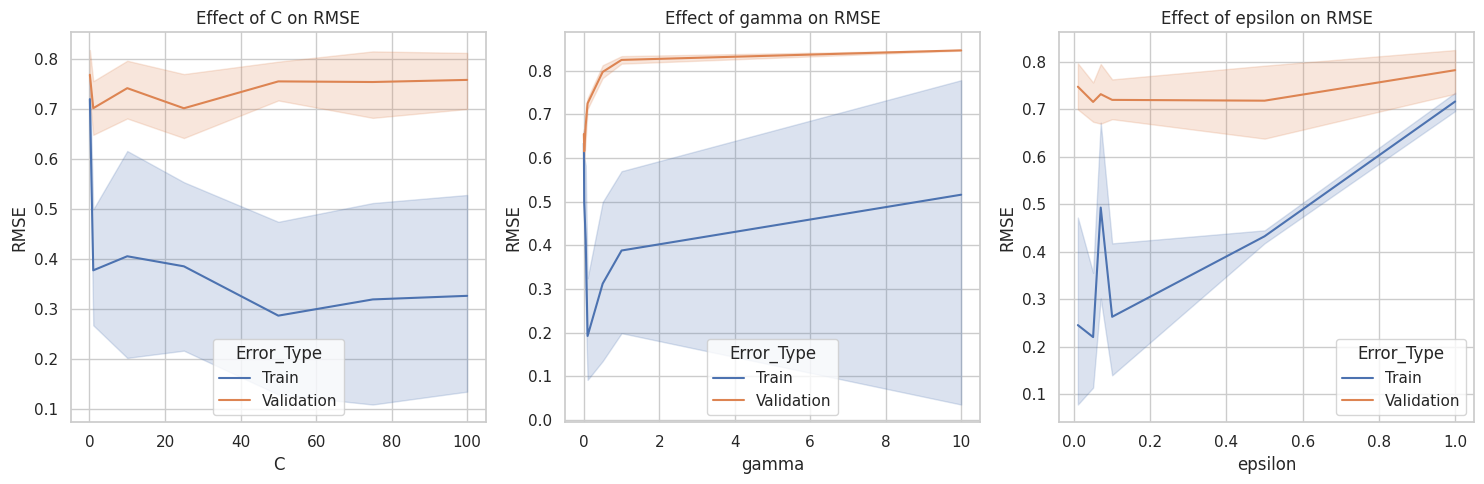

In [19]:
# 绘制超参数搜索结果图，多幅图，每幅图展示一个超参数对模型性能的影响
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=model_metrics, x='C', y='RMSE', hue='Error_Type')
plt.title('Effect of C on RMSE')
plt.xlabel('C')
plt.ylabel('RMSE')
plt.subplot(1, 3, 2)
sns.lineplot(data=model_metrics, x='gamma', y='RMSE', hue='Error_Type')
plt.title('Effect of gamma on RMSE')
plt.xlabel('gamma')
plt.ylabel('RMSE')
plt.subplot(1, 3, 3)
sns.lineplot(data=model_metrics, x='epsilon', y='RMSE', hue='Error_Type')
plt.title('Effect of epsilon on RMSE')
plt.xlabel('epsilon')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

### Test

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  10.3s
Model training completed!
[Train Error] Evaluating DFT SVR on train set:


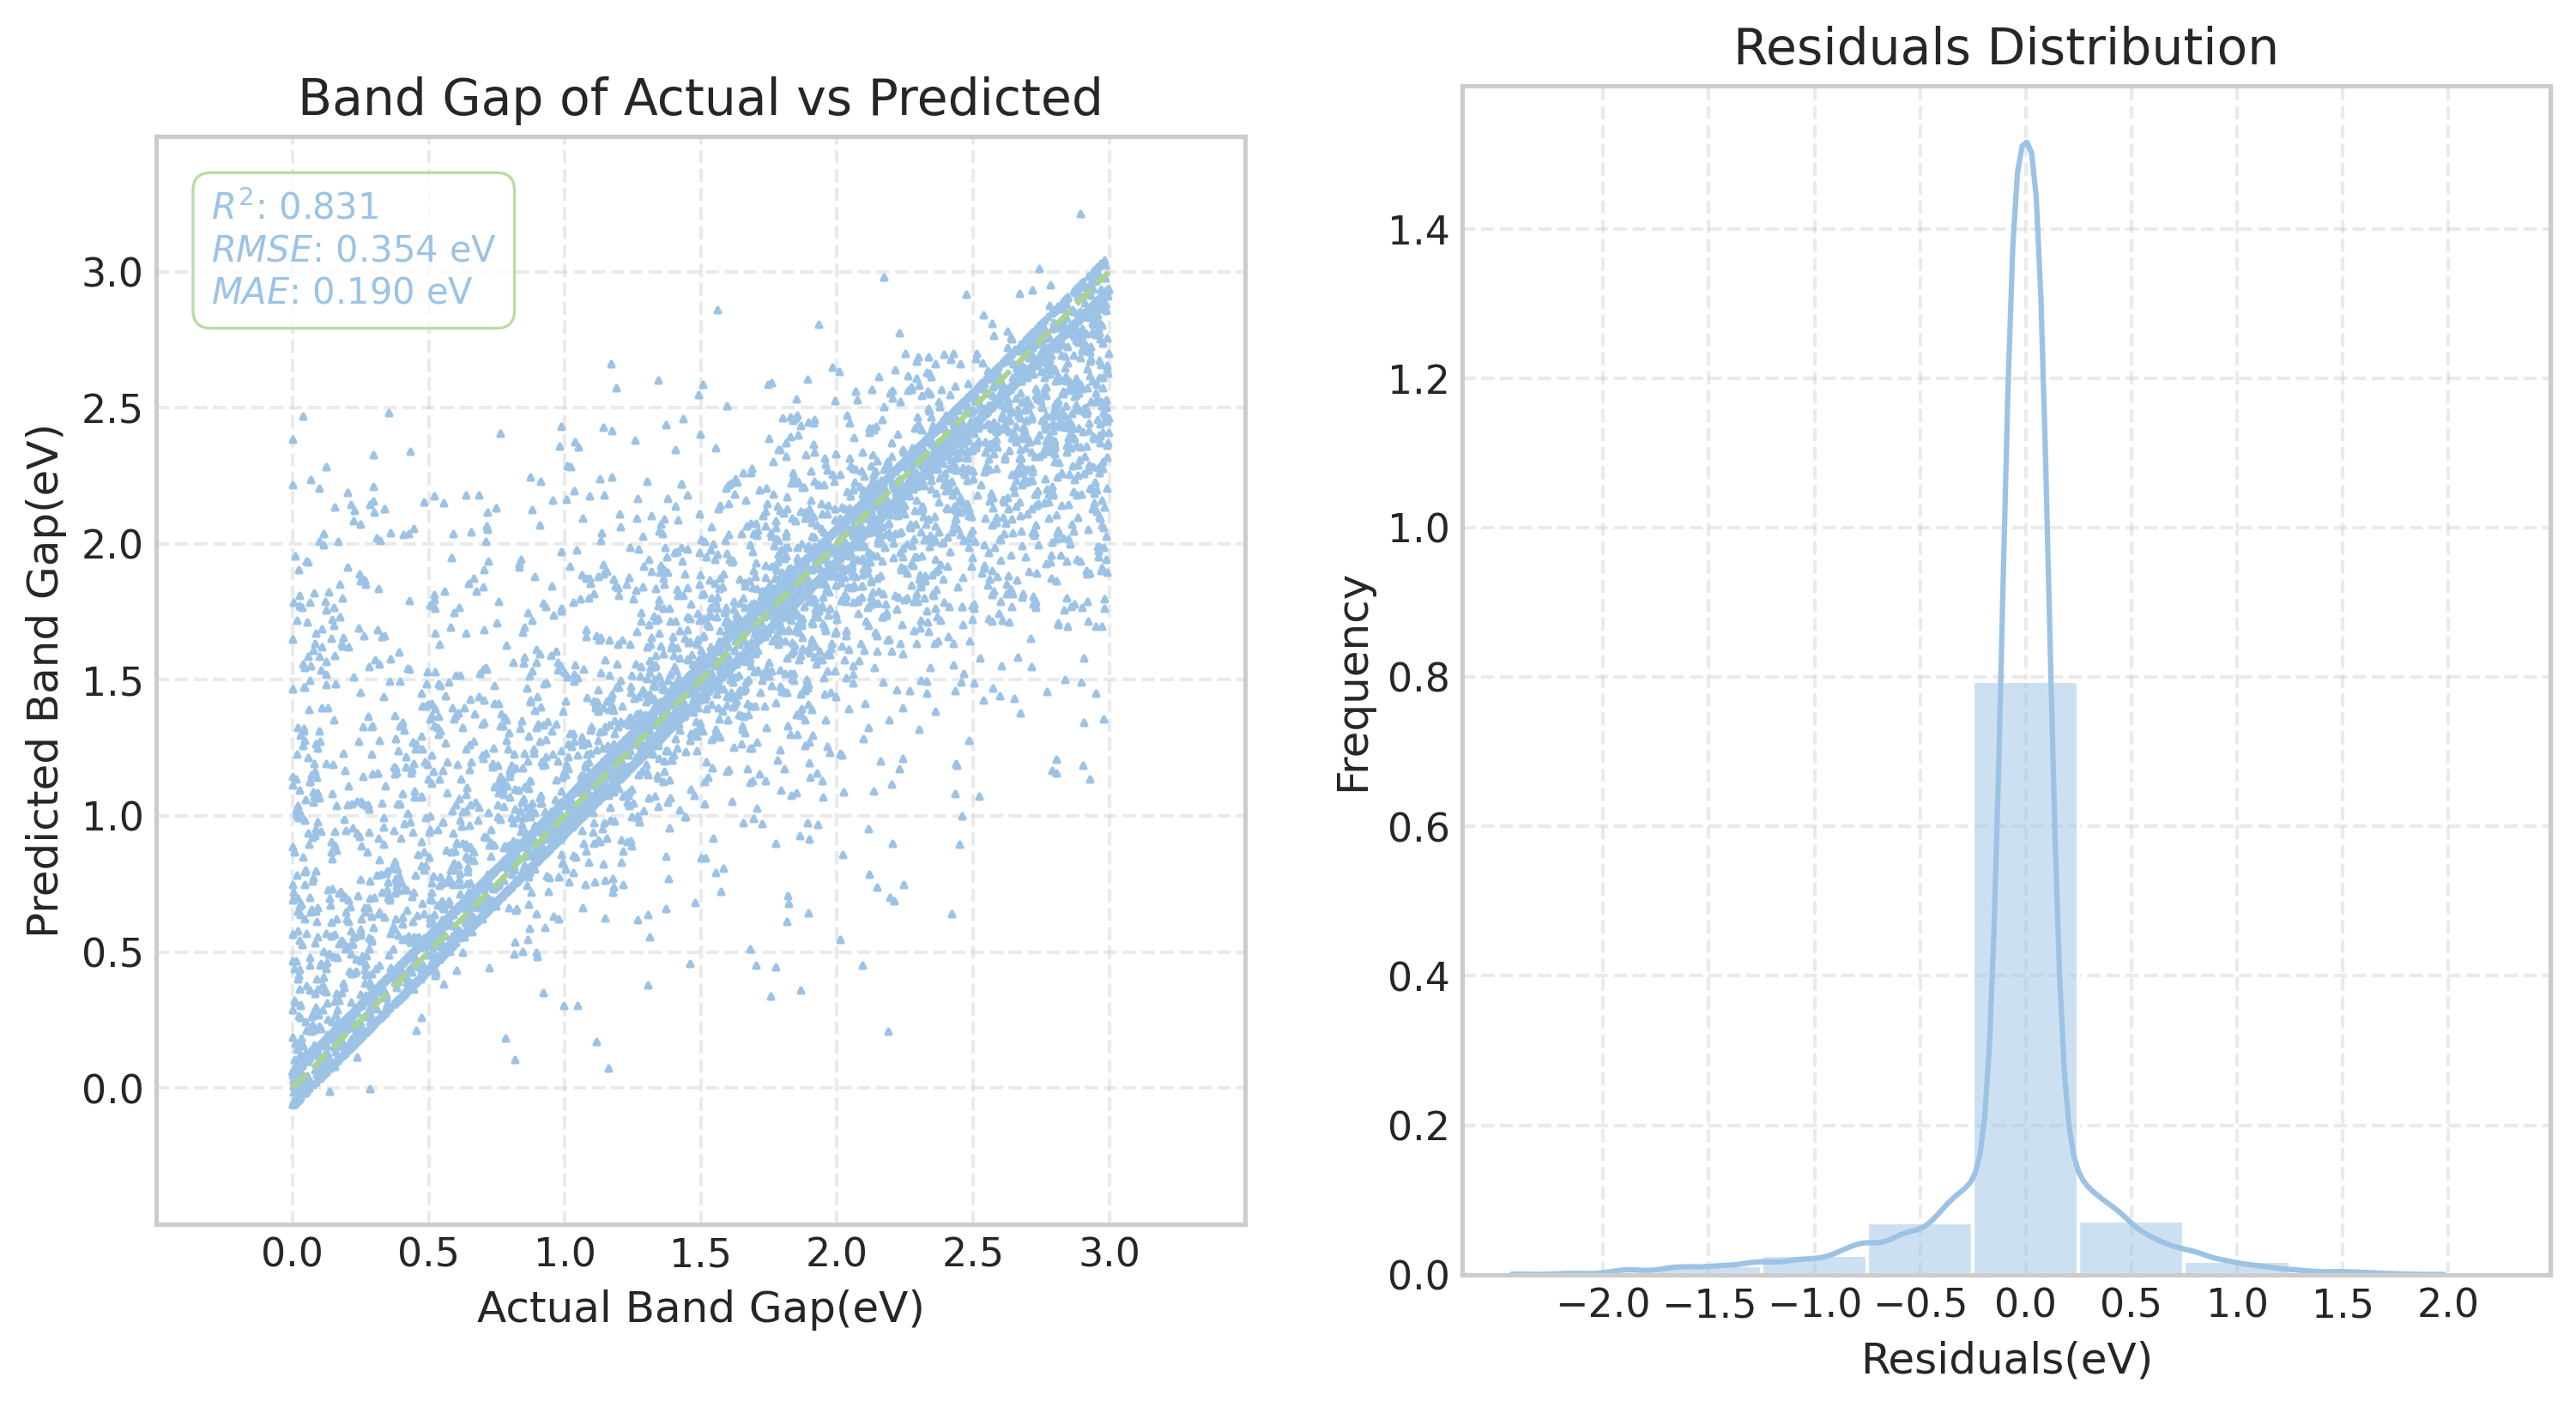


Model Evaluation Results:
Test set size: 8268
Test set: R²: 0.8310 RMSE: 0.3541 MAE: 0.1903 MAPE: 1152.7624%
[Test Error] Evaluating DFT SVR on test set:


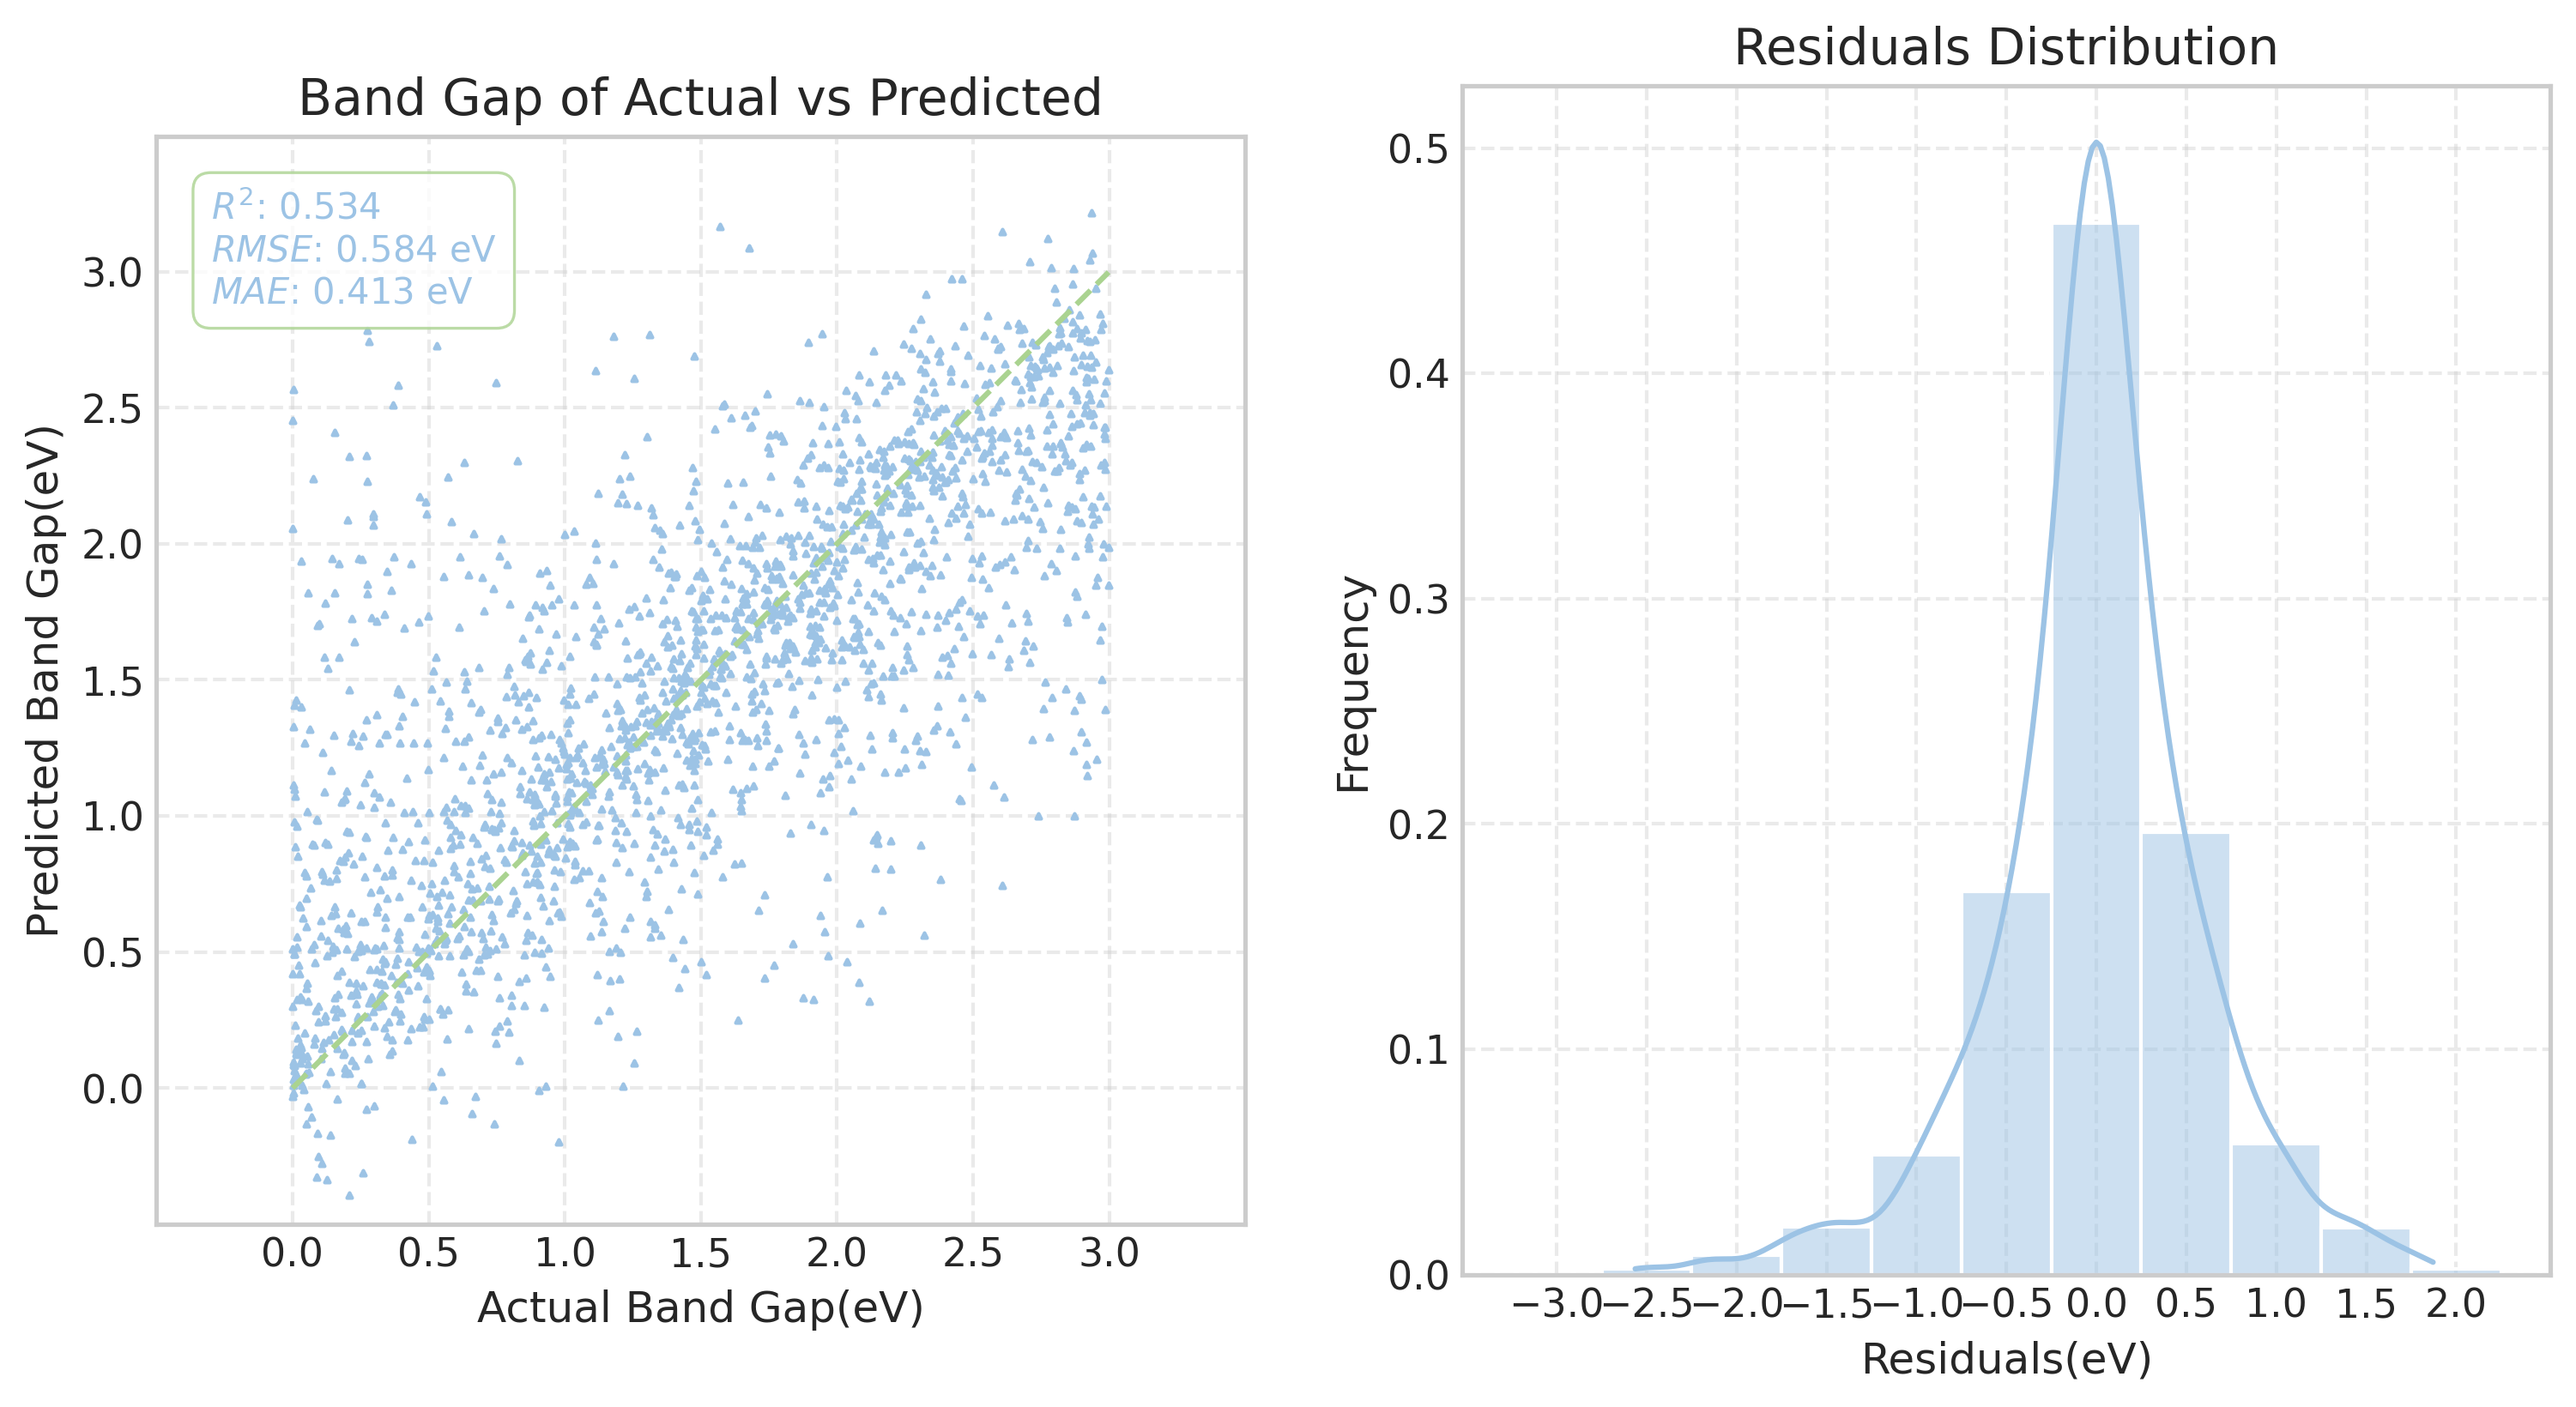


Model Evaluation Results:
Test set size: 2074
Test set: R²: 0.5336 RMSE: 0.5841 MAE: 0.4130 MAPE: 1053.8467%


In [ ]:
best_svr = SVR(kernel='rbf', C=best_val_params['C'], epsilon=best_val_params['epsilon'], gamma=best_val_params['gamma'])
model = SingleModel(model=best_svr)
model.train(dft_all_train_X, dft_all_train_y)
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on train set:")
    
train_metrics = model.evaluate(dft_all_train_X, dft_all_train_y, fig_show=True)
# evaluate on the dft test set
print(f"[Test Error] Evaluating DFT {MODEL_NAME} on test set:")
test_metrics = model.evaluate(dft_test_X, dft_test_y, fig_show=True)